# - Main Content
frame
1. autograd frame: jax, jax.numpy
2. neural network frame: flax
3. optimizer frame: optax

requrement
- [x] complex net: conv1d, GRUCell, FCN, GRU net
- [ ] complex actvation function.
- [x] complex optimizer: take real parameter !!
torch support: sgd, adam
optax support: None

some operations from pytorch to jax.numpy
1. jnp.transpose(x,[0,1,2]): permute the axes of an array
2. jnp.expand_dims(x, axis): add a dim to x
3. jnp.repeat: repeat a dim
4. jnp.squeeze: Remove axes of length one from a.
5. jnp.concatenate
6. jnp.stack

## 1-Static Module: optimize with complex parameters

In [2]:
import jax
import jax.numpy as jnp
from jax import device_put, device_get
import jax.random as random
import numpy as np
import flax.linen as nn
import optax
from functools import partial, wraps
from typing import Any, NamedTuple
from optical_flax.utils import realize, normal_init, show_tree, tree_r2c, tree_c2r
from collections import namedtuple
from flax.core import freeze, unfreeze

# 6. 复数优化代码: static module
class NN(nn.Module):
    @nn.compact
    def __call__(self, inputs):
        x = inputs  # NWC
        conv = partial(nn.Conv,features=1,kernel_size=(3,), param_dtype=jnp.complex64, dtype=jnp.complex64)
        x = conv()(x) # NWC
        x = nn.relu(x.real) + nn.relu(x.imag) * (1j) # NWC
        x = nn.DenseGeneral(features=1, param_dtype=jnp.complex64, dtype=jnp.complex64, axis=(-2,-1))(x) # N1
        return x

net_org = NN()
net = realize(net_org)

N,W,C = 5,1000,2
x0 = np.random.rand(N,W,C) + 1j * np.random.rand(N,W,C)
x0 = device_put(x0)

param_true = net.init(random.PRNGKey(123), x0)
y0 = net.apply(param_true, x0)
param = net.init(random.PRNGKey(234), x0)

from commplax import optim
f = optim.piecewise_constant([500, 1000], [2e-3, 1e-4, 1e-5])
tx = optax.adam(learning_rate=f)
opt_state = tx.init(param)

@jax.jit
def MSE(f_hat, f):
    return jnp.sum(jnp.abs(f_hat - f)**2)

@jax.jit
def loss(params,x0,y0):
    y1 = net.apply(params, x0)
    return MSE(y1,y0)

loss_grad_fn = jax.jit(jax.value_and_grad(loss))

State = namedtuple('TrainState', ['params','opt_state'])
Data = namedtuple('Data', ['x','y'])
data = Data(x=x0,y=y0)

@jax.jit
def update_state(state, data):
    loss_val, grads = loss_grad_fn(state.params, data.x, data.y)
    updates,opt_state = tx.update(grads, state.opt_state)
    params = optax.apply_updates(state.params, updates)
    return State(params=params, opt_state=opt_state), loss_val
    
## training 不用 scan
loss_list = []
state = State(params=param, opt_state=opt_state)
for i in range(1000):
    state, loss_val = update_state(state, data)
    loss_list.append(loss_val)
    if i % 100 == 0:
        print(loss_val)

/home/xiaoxinyu/.conda/envs/commplax/lib/python3.8/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


0.0459302
1.9343497e-07
5.5248852e-12
1.6181717e-16
2.1684043e-18
3.80826e-18
1.3552527e-18
1.3552527e-18
1.3552527e-18
1.3552527e-18


## 2-Dynamic module: applying and training

In [ ]:
class LeADF(nn.Module):
    @nn.compact
    def __call__(self,inputs):
        ## 探索variable的更新机制
        x = inputs

        # 定义中间变量
        running_mean = self.variable('af','mean',lambda s: jnp.ones(s), (1,))

        # 更新中间变量
        mean = jnp.sum(x**2)
        running_mean.value = running_mean.value * 0.99 + mean * (1 - 0.99)

        # 返回最终值
        return x / jnp.sqrt(running_mean.value)

class LeDSP(nn.Module):
    @nn.compact
    def __call__(self, inputs):
        x = inputs   # NWC
        x = nn.Dense(features=5)(x)  # N1
        x = LeADF()(x)
        return x

def test_net(net, mutable='af', train_key='params'):
    N,W,C = 5,1000,2
    x0 = np.random.rand(N,W,C) + 1j * np.random.rand(N,W,C)
    x0 = device_put(x0)

    var_true = net.init(random.PRNGKey(123), x0)
    y0, real_af_state = net.apply(var_true, x0, mutable=mutable)
    var = net.init(random.PRNGKey(234), x0)


    tx = optax.adam(learning_rate=0.001)
    opt_state = tx.init(var[train_key])


    @jax.jit
    def MSE(f_hat, f):
        return jnp.sum(jnp.abs(f_hat - f)**2)

    @jax.jit
    def loss(params,af_state,x0,y0):
        var = freeze({train_key:params, mutable: af_state})
        y1, new_af_state = net.apply(var, x0, mutable=mutable)
        return MSE(y1,y0), new_af_state

    loss_grad_fn = jax.jit(jax.value_and_grad(loss, has_aux=True))

    State = namedtuple('TrainState', ['params','af_state','opt_state'])
    Data = namedtuple('Data', ['x','y'])
    data = Data(x=x0,y=y0)

    @partial(jax.jit,static_argnums=(2))
    def update_state(state, data, tx):
        (loss_val,new_af_state), grads = loss_grad_fn(state.params,state.af_state, data.x, data.y)
        updates,opt_state = tx.update(grads, state.opt_state)
        params = optax.apply_updates(state.params, updates)
        return State(params=params,af_state=new_af_state[mutable], opt_state=opt_state), loss_val
        
    ## training 不用 scan
    loss_list = []
    state = State(params=var[train_key],af_state=var[mutable], opt_state=opt_state)
    for i in range(1000):
        state, loss_val = update_state(state, data, tx)
        loss_list.append(loss_val)
        if i % 100 == 0:
            print(loss_val)
    return state

In [ ]:
key = jax.random.PRNGKey(123)
net = LeDSP()
show_tree(net.init(key, jnp.ones([10])))

In [ ]:
DSP_vmap = nn.vmap(LeDSP, variable_axes={'params':None, 'af':0}, split_rngs={'params':False, 'af':False}, in_axes=0,out_axes=0)
net = DSP_vmap()
var = net.init(key, jnp.ones([5,10]))
show_tree(var)

In [ ]:
net.apply(var, jnp.ones([5,10]), mutable='af')

In [ ]:
## dynamic module
net_org = LeDSP()
net = realize(net_org)
state = test_net(net)
#var = net.init(random.PRNGKey(0),x0)

## 3-Use the NN internal module

In [ ]:
## 利用NN内部模块
import jax
import jax.numpy as jnp
import flax.linen as nn

class AutoEncoder(nn.Module):
  def setup(self):
    self.encoder = nn.Dense(3)
    self.decoder = nn.Dense(5)

  def __call__(self, x):
    return self.decoder(self.encoder(x))

x = jnp.ones((16, 9))
ae = AutoEncoder()
variables = ae.init(jax.random.PRNGKey(0), x)
model = ae.bind(variables)
z = model.encoder(x)
x_reconstructed = model.decoder(z)

## 4-Dense layer

In [ ]:
## Dense layer: act on the last dimension of x
key = random.PRNGKey(0)
net = nn.Dense(features=1, kernel_init=normal_init, bias_init=normal_init, param_dtype=jnp.complex64, dtype=jnp.complex64)
x = jnp.ones([5,100,3])+1j
params = net.init(key, x)
net.apply(params, x).shape

## 5-DenseGeneral layer

In [ ]:
## DenseGeneral: flexible axies
# 会把作用的axis移到最后一个轴
net = nn.DenseGeneral(features=1, kernel_init=normal_init, bias_init=normal_init,param_dtype=jnp.complex64, dtype=jnp.complex64, axis=(1))
x = jnp.ones([5,100,3,4])
params = net.init(key, x)
net.apply(params, x).shape

## 6-Conv Layer

In [11]:
## conv layer: input: NWC
key = random.PRNGKey(0)
net = nn.Conv(features=2,kernel_size=(5,),strides=(1,),kernel_init=normal_init, param_dtype=jnp.complex64,dtype=jnp.complex64, padding='same')
x = jnp.ones([100,2])
params = net.init(key, x)
net.apply(params, x).shape

(100, 2)

In [16]:
params['params']['kernel']

DeviceArray([[[ 0.61671954-1.1479251j ,  0.4116587 -1.1703161j ],
              [-0.6803877 +1.8869159j , -1.0771589 -2.956864j  ]],

             [[ 1.093049  -0.5451637j , -0.30176464-1.1562319j ],
              [-0.02704463+0.15091111j, -0.98426235-1.0273948j ]],

             [[ 0.23458725+0.7263101j , -0.49715957-0.25519085j],
              [ 0.14015824-0.9344177j , -0.7609234 +0.04437318j]],

             [[ 0.6508459 +0.14902635j, -1.4419343 -0.3645799j ],
              [-0.25551254-0.03396091j,  1.110661  +0.98137975j]],

             [[-0.8319209 -0.9487293j , -0.1314315 -0.2733951j ],
              [ 2.2706056 -0.6598578j ,  1.1973985 +1.0825701j ]]],            dtype=complex64)

: 

In [4]:
import flax.linen.initializers as il
import jax.random as rd
import jax.numpy as jnp
f = il.lecun_normal()
f(rd.PRNGKey(0),(3,4),dtype=jnp.complex64)

DeviceArray([[-0.7605683 +0.28631905j,  0.29151273-0.67799926j,
              -0.20389351+0.41539636j, -0.5023387 -0.13513811j],
             [ 0.07023317+0.50040025j,  0.22861177-0.52747107j,
              -0.1865903 -0.26013976j, -0.8336339 -0.25228372j],
             [ 0.24960287-0.3144836j , -0.16420667-0.10366028j,
               0.5363082 +0.01821979j,  0.5512331 -0.08523721j]],            dtype=complex64)

: 

## 7-GRU layer

In [ ]:
## GRUCell
net = nn.GRUCell()
params = net.init(key, jnp.ones([10,5]), jnp.ones([10,11]))
carry, output = net.apply(params, jnp.ones([10,5]), jnp.ones([10,11]))
print(carry.shape, output.shape)

## GRU
import flax
import flax.linen as nn
from jax import random

class GRU(nn.Module):
  param_dtype:Any=jnp.float32
  dtype:Any=jnp.float32
  kernel_init: Any=normal_init
  bias_init:Any=normal_init
  @nn.compact
  def __call__(self, c, xs):
    NN = nn.scan(nn.GRUCell,
                   variable_broadcast="params",
                   split_rngs={"params": False},
                   in_axes=1,   # along axis=1 scan
                   out_axes=1)  # output on axis=1
    return NN(param_dtype=self.param_dtype, dtype=self.dtype, kernel_init=self.kernel_init, bias_init=self.bias_init)(c, xs)

seq_len, batch_size, in_feat, out_feat = 20, 16, 3, 5
key_1, key_2, key_3 = random.split(random.PRNGKey(0), 3)

xs = random.uniform(key_1, (batch_size, seq_len, in_feat))
init_carry = nn.GRUCell.initialize_carry(key_2, (batch_size,), out_feat).astype(jnp.complex64)

model = GRU(param_dtype=jnp.complex64, dtype=jnp.complex64)
variables = model.init(key_3, init_carry, xs)
out_carry, out_val = model.apply(variables, init_carry, xs)

assert out_val.shape == (batch_size, seq_len, out_feat)
print(f'out_carry shape: {out_carry.shape}, out_val shape {out_val.shape}')
print(f'init_carry shape: {init_carry.shape}')

## 8-Dense net

In [ ]:
from typing import Callable
from optical_flax.functions import cleaky_relu, crelu
from commplax.module.core import SigTime, Signal, zeros
class Dense_net(nn.Module):
    '''
    Fully Connected network
    '''
    features:int = 20
    width:list = (20,20,20)
    dtype:Any = jnp.complex64
    param_dtype:Any = jnp.complex64
    act:Callable=crelu
    bias_init:Callable=zeros

    @nn.compact
    def __call__(self,inputs):
        Dense  = partial(nn.Dense, dtype=self.dtype, param_dtype=self.param_dtype)
        x = inputs
        for w in self.width:
            x = Dense(features=w,bias_init=zeros)(x)
            x = self.act(x)
        x = Dense(features=self.features, bias_init=self.bias_init)(x)
        return x

## 9-nn.vmap on static module

In [ ]:
def nn_vmap_x(module):
    return nn.vmap(module, 
    variable_axes={'params':-1},  # 表示变量'params'会沿着axis=-1复制, 'const'不会复制
    split_rngs={'params':True}, # 表示初始化的种子会split
    in_axes=-1, out_axes=-1) 

In [ ]:
# FDBP Module
class myFDBP(nn.Module):
    # 定义初始化参数的函数
    dtype: Any=jnp.complex64
    weight_init: Callable=normal_init
    bias_init: Callable=normal_init
    steps: int = 3
    dtaps: int = 261
    ntaps: int = 41

    def setup(self):
        conv_c = partial(nn.Conv, use_bias=False, dtype=jnp.complex64, param_dtype=jnp.complex64, kernel_init=self.weight_init)
        conv_r = partial(nn.Conv, use_bias=False, dtype=jnp.float32, param_dtype=jnp.float32, kernel_init=self.weight_init)
        self.dconv_x = [conv_c(features=1, kernel_size=(self.dtaps,)) for i in range(self.steps)]
        self.dconv_y = [conv_c(features=1, kernel_size=(self.dtaps,)) for i in range(self.steps)]
        self.nconv = [conv_r(features=2, kernel_size=(self.ntaps,)) for i in range(self.steps)]

    @nn.compact
    def __call__(self,inputs):
        p = inputs

        # 定义模型参数
        for i in range(self.steps):
            x = p[:,0:1]
            y = p[:,1:2]
            x = self.dconv_x[i](x)
            y = self.dconv_y[i](y)
            p = jnp.concatenate([x,y],axis=1)
            arg = self.nconv[i](jnp.abs(p)**2)
            p = p * jnp.exp(1j*(arg))
            

        # 运算与返回
        return p

## 10-test long GRU (batch training)

In [ ]:
## test long GRU
from optical_flax.layers import GRU
seed = random.PRNGKey

net = realize(GRU())
L, B, in_feat, out_feat = 10000, 5, 3, 2
key_1, key_2, key_3 = random.split(random.PRNGKey(0), 3)

xs = random.uniform(key_1, (B,L,in_feat))
init_carry = nn.GRUCell.initialize_carry(key_2, (B,), out_feat).astype(jnp.complex64)
var_true = net.init(key_3, init_carry, xs)
out_carry,ys = net.apply(var_true, init_carry, xs)
var = net.init(seed(10), init_carry, xs)

tx = optax.adam(learning_rate=0.01)


def loss_fn(var, carry, xs, ys):
    out_carry, y = net.apply(var, carry, xs)
    return jnp.sum(jnp.abs(y - ys)**2), out_carry

from jax.lax import stop_gradient 


## 由于jax没有计算图的概念，所以在这里并不需要 stop_gradient
@jax.jit
def update_step(var,opt_state, carry, xs, ys):
    (loss_val, out_carry), grads = jax.value_and_grad(loss_fn, has_aux=True)(var, carry, xs, ys)
    updates,opt_state = tx.update(grads, opt_state)
    var = optax.apply_updates(var, updates)
    return var, opt_state, stop_gradient(out_carry), loss_val


carry = init_carry
opt_state = tx.init(var)
epochs = 200
for j in range(epochs):
    for i in range(100):
        x = xs[:,i*100:(i+1)*100,:]
        y = ys[:,i*100:(i+1)*100,:]
        var, opt_state,carry,l  = update_step(var, opt_state, carry, x, y)
    if j % 10==0:
        print(l)


## 11-dispersion perator

In [ ]:
import jax
import jax.numpy as jnp
from jax import device_put, device_get
import jax.random as random
import numpy as np
import flax.linen as nn
import optax
from functools import partial, wraps
from typing import Any, NamedTuple,Callable, Iterable, Optional, Tuple, Union,Sequence
from optical_flax.utils import realize, normal_init, show_tree, tree_r2c, tree_c2r
from collections import namedtuple
from flax.core import freeze, unfreeze
from commplax.module import core
from commplax.module.core import SigTime, Signal, zeros, conv1d_t, vmap,wpartial,delta,gauss
import optical_flax.base as base
import optical_flax.layers as layers
import optax
import matplotlib.pyplot as plt
## Define datax
from gdbp import gdbp_base as gb, data as gdat, aux
data_train = gdat.load(1, 0, 4, 2)[0]
data_test = gdat.load(2, 0, 4, 2)[0]

In [ ]:
## dispersion operator
a = data_train.a
pi  = np.pi
log = np.log
exp = np.exp
ifft = np.fft.ifft

# virtual span is used in cases where we do not use physical span settings
freqs = 1001
sample_rate = a['samplerate']
span_length = a['distance'] / a['spans']
spans = a['spans']
launch_power = a['lpdbm'] - 3   # launch power [dBm]
                             
steps_per_span=1                                 # steps per span
virtual_spans=3                                  # number of virtual spans
carrier_frequency=299792458/1550E-9              # carrier frequency [Hz]
fiber_dispersion=16.5E-6                         # [s/m^2]
fiber_dispersion_slope=0.08e3                    # [s/m^3]
fiber_loss=.2E-3                                 # loss of fiber [dB/m]
fiber_core_area=80E-12                           # effective area of fiber [m^2]
fiber_nonlinear_index=2.6E-20                    # nonlinear index [m^2/W]
fiber_reference_frequency=299792458/1550E-9      # fiber reference frequency [Hz]
ignore_beta3=True
polmux=True

C       = 299792458. # speed of light [m/s]
lambda_ = C / fiber_reference_frequency
B_2     = -fiber_dispersion * lambda_**2 / (2 * pi * C)
B_3     = 0. if ignore_beta3 else \
    (fiber_dispersion_slope * lambda_**2 + 2 * fiber_dispersion * lambda_) * (lambda_ / (2 * pi * C))**2 #[/m/W]
gamma   = 2 * pi * fiber_nonlinear_index / lambda_ / fiber_core_area  #[/m/W]
LP      = 10.**(launch_power / 10 - 3)  # 将【dBm】转化为 [W]
alpha   = fiber_loss / (10. / log(10.)) # 计算出方程中的衰减系数alpha，z单位 [m]
L_eff   = lambda h: (1 - exp(-alpha * h)) / alpha
NIter   = virtual_spans * steps_per_span
delay   = (freqs - 1) // 2
dw      = 2 * pi * (carrier_frequency - fiber_reference_frequency)
w_res   = 2 * pi * sample_rate / freqs
k       = np.arange(freqs)
w       = np.where(k > delay, k - freqs, k) * w_res # ifftshifted

H   = exp(-1j * (-B_2 / 2 * (w + dw)**2 + B_3 / 6 * (w + dw)**3) * \
            span_length * spans / virtual_spans / steps_per_span)
            ## dz = span_length * spans / virtual_spans / steps_per_span
H_casual = H * exp(-1j * w * delay / sample_rate) ## 频域相位旋转等价于时域平移，将时域对齐
h_casual = ifft(H_casual)

if polmux:
        dims = 2
else:
    dims = 1

H = np.tile(H[None, :, None], (NIter, 1, dims))
h_casual = np.tile(h_casual[None, :, None], (NIter, 1, dims))

plt.plot(np.abs(h_casual[2,:,1]))

## 12-kalman filter

In [ ]:
import numpy as np

class KalmanFilter(object):
    def __init__(self, F = None, B = None, H = None, Q = None, R = None, P = None, x0 = None):

        if(F is None or H is None):
            raise ValueError("Set proper system dynamics.")

        self.n = F.shape[1]
        self.m = H.shape[1]

        self.F = F
        self.H = H
        self.B = 0 if B is None else B
        self.Q = np.eye(self.n) if Q is None else Q
        self.R = np.eye(self.n) if R is None else R
        self.P = np.eye(self.n) if P is None else P
        self.x = np.zeros((self.n, 1)) if x0 is None else x0

    def predict(self, u = 0):
        self.x = np.dot(self.F, self.x) + np.dot(self.B, u)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q
        return self.x

    def update(self, z):
        y = z - np.dot(self.H, self.x)
        S = self.R + np.dot(self.H, np.dot(self.P, self.H.T))
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
        self.x = self.x + np.dot(K, y)
        I = np.eye(self.n)
        self.P = np.dot(I - np.dot(K, self.H), self.P)

def example():
    dt = 1.0/60
    F = np.array([[1, dt, 0], [0, 1, dt], [0, 0, 1]])
    H = np.array([1, 0, 0]).reshape(1, 3)
    Q = np.array([[0.05, 0.05, 0.0], [0.05, 0.05, 0.0], [0.0, 0.0, 0.0]])
    R = np.array([1]).reshape(1, 1)
    
    itr  = 200
    
    def f(x):
        return np.dot(F,x)+np.random.normal(0,5,3)
    
    real_state = []
    x = np.array([0,0,0])
    
    for i in range(itr):
        real_state.append(x[0])
        x = f(x)
    
    measurements = [x-1+np.random.normal(0,1) for x in real_state]

    kf = KalmanFilter(F = F, H = H, Q = Q, R = R)
    predictions = []
    for z in measurements:
        predictions.append(kf.predict()[0])
        kf.update(z)

    import matplotlib.pyplot as plt
    plt.plot(range(len(measurements)), measurements, label = 'Measurements')
    plt.plot(range(len(predictions)), np.array(predictions), label = 'Kalman Filter Prediction')
    plt.plot(range(len(real_state)), real_state, label = 'Real statement' )
    plt.legend()
    plt.show()

example()

## 13-complex optimizer

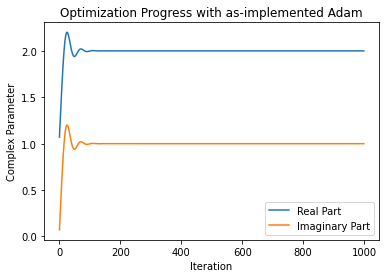

In [89]:
## torch adam optimize complex parameter
import torch as t
from matplotlib import pyplot as plt

complex_param = t.tensor([1],dtype=t.complex64, requires_grad=True)


# We will optimize on the mean squared error from a 1j
target = 2.0 +(1j)

def calc_loss(x):
    return t.abs(x - target)**2

optimizer = t.optim.Adam([complex_param], lr=0.1)

n = 1000
loss_list = []
values = t.zeros(n, dtype=t.complex64)
for i in range(n):
    optimizer.zero_grad()
    loss = calc_loss(complex_param)
    loss.backward()
    optimizer.step()
    values[i] = complex_param.detach()
    loss_list.append(loss.item())


# Plot the results
plt.plot(values.real, label='Real Part')
plt.plot(values.imag, label='Imaginary Part')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Complex Parameter')
plt.title('Optimization Progress with as-implemented Adam')
plt.show()

In [92]:
jnp.ones(3).conj()

DeviceArray([1., 1., 1.], dtype=float32)

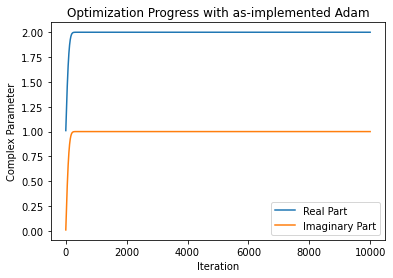

In [129]:
## torch adam optimize complex parameter
import torch as t
from matplotlib import pyplot as plt
a = t.tensor([1.0], requires_grad=True)
b = t.tensor([0.0], requires_grad=True)


# We will optimize on the mean squared error from a 1j
target = 2.0 +(1j)

def calc_loss(x):
    xc = x[0] + x[1]*(1j)
    return t.abs(xc - target)**2

optimizer = t.optim.Adam([a,b], lr=0.01)

n = 10000
loss_list = []
values = t.zeros(n, dtype=t.complex64)
for i in range(n):
    optimizer.zero_grad()
    loss = calc_loss([a,b])
    loss.backward()
    optimizer.step()
    values[i] = a.detach() + b.detach()*(1j)
    loss_list.append(loss.item())


# Plot the results
plt.plot(values.real, label='Real Part')
plt.plot(values.imag, label='Imaginary Part')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Complex Parameter')
plt.title('Optimization Progress with as-implemented Adam')
plt.show()

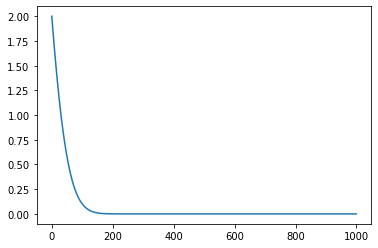

: 

In [147]:
## optax complex parameter 优化
from optical_flax.initializers import ones
from optical_flax.utils import realize
net = nn.Dense(1, use_bias=False,kernel_init=ones, dtype=jnp.complex64, param_dtype=jnp.complex64)
net = realize(net)
param = net.init(key, jnp.ones(1))
tx = optax.adam(learning_rate=0.01)
opt_state = tx.init(param)
x = jnp.ones(1)
y = jnp.array(2.0 + 1j)

def loss(param):
    return jnp.sum(jnp.abs(net.apply(param,x) - y)**2)

@jax.jit
def update_state(param, opt_state):
    loss_val, grads = jax.value_and_grad(loss)(param)
    updates, opt_state = tx.update(grads,opt_state)
    param = optax.apply_updates(param, updates)
    return param,opt_state, loss_val 

n=1000
loss_list=[]
for i in range(n):
    param,opt_state, loss_val = update_state(param, opt_state)
    loss_list.append(loss_val)

import matplotlib.pyplot as plt
plt.plot(loss_list)

## 14-nn.vmap on dynamic module

In [ ]:
class Foo(nn.Module):
    @nn.compact
    def __call__(self, x, train=True):
        x = nn.Conv(3, kernel_size=(3, 3), strides=(1, 1), padding="SAME")(x)
        x = nn.BatchNorm(use_running_average=not train, axis_name=["b1", "b2"])(
            x
        )  # I need add two extra batch dims, can we use a list of axis_name here?
        x = nn.relu(x)
        return x


In [ ]:
net = Foo()
var = net.init(key, jnp.ones([2,28,28,3]))

In [ ]:
show_tree(var)

In [ ]:
import functools

import flax.linen as nn
import jax
from jax import numpy as jnp


@functools.partial(
    nn.vmap,
    variable_axes={"params": None, "batch_stats": None},
    split_rngs={"params": False},
    in_axes=(1, None),
    out_axes=1,
    axis_name="b2",
)
@functools.partial(
    nn.vmap,
    variable_axes={"params": None, "batch_stats": None},
    split_rngs={"params": False},
    in_axes=(1, None),
    out_axes=1,
    axis_name="b1",
)
class Foo(nn.Module):
    @nn.compact
    def __call__(self, x, train=True):
        x = nn.Conv(3, kernel_size=(3, 3), strides=(1, 1), padding="SAME")(x)
        x = nn.BatchNorm(use_running_average=not train, axis_name=["b1", "b2"])(
            x
        )  # I need add two extra batch dims, can we use a list of axis_name here?
        x = nn.relu(x)
        return x



foo = Foo()
x = jnp.ones(shape=(2, 2, 2, 28, 28, 3))
rng = jax.random.PRNGKey(0)
vars = foo.init({"params": rng}, x, True)
print("vars:")
print(jax.tree_map(lambda x: x.shape, vars))

train_y, new_batch_stats = foo.apply(
    {"params": vars["params"], "batch_stats": vars["batch_stats"]},
    x,
    True, # the trick is use False, instead of train=True
    mutable=["batch_stats"],
)
print("train y")
print(train_y.shape)
infer_y = foo.apply(
    {"params": vars["params"], "batch_stats": new_batch_stats["batch_stats"]},
    x,
    False, # the trick is use False, instead of train=False
    mutable=False,
)
print("infer_y shape:")
print(infer_y.shape)

## 15-jax.vmap

In [ ]:
from functools import partial, wraps
x = (0,1)
y = {'a':3,'b':{'alpha':4, 'beta':5}}

def expand(data):
    return jax.tree_map(lambda x: jnp.ones([5,1])*x, data)

x_ = expand(x)
y_ = expand(y)

In [ ]:
def time_dc(f):
    @wraps(f)
    def _f(*args, **kwargs):
        import time
        t0 = time.time()
        y = f(*args, **kwargs)
        t1 = time.time()
        print(f'time cost = {t1-t0}')
        return y
    return _f
    

In [ ]:
@partial(jax.vmap, in_axes=(None, {'a':0, 'b':{'alpha':0,'beta':0}}), out_axes=(None,1))
def f(x,y):
    return x[0], {'aa':y['b']['alpha'], 'bb':y['b']['beta']}


In [ ]:
f(x,y_)

In [ ]:
import jax
import numpy as np
import jax.numpy as jnp

X = jnp.ones(10)
Y = jnp.arange(10)


def poisson(alpha, beta):
    lamb = alpha + beta*X
    return jnp.where(lamb.any() < 0, 0, jnp.sum(Y*jnp.log(lamb) - jnp.log(lamb)))

poisson_vmap = jax.jit(jax.vmap(poisson, in_axes=(-1,-1), out_axes=-1))
alpha = jnp.ones([1,10])
beta = jnp.ones([1,10])
poisson_vmap(alpha,beta)

## 16-Module transformation

In [ ]:
import jax
from jax import random, numpy as jnp
from flax import linen as nn

class MLP(nn.Module):
  @nn.compact
  def __call__(self, xs):
    h = nn.Dense(4, name='hidden')(xs)
    h = nn.relu(h)
    return nn.Dense(1, name='out')(h)

class ManualVmapMLP(nn.Module):
  @nn.compact
  def __call__(self, xs):
    mlp = MLP(parent=None)
    init_fn = lambda rng, xs: jax.vmap(mlp.init, in_axes=0)(random.split(rng, xs.shape[0]), xs)['params']
    apply_fn = jax.vmap(mlp.apply, in_axes=0)
    mlp_params = self.param('mlp', init_fn, xs)
    return apply_fn({'params': mlp_params}, xs)

xs = jnp.ones((3, 4))
variables = ManualVmapMLP().init(random.PRNGKey(0), xs)
print(jax.tree_map(jnp.shape, variables['params']))

In [ ]:
def trans(x):
    H = jnp.ones(len(x))
    x = jnp.fft.ifft(jnp.fft.fft(x)*H)
    x = jnp.exp(1j*jnp.abs(x)**2)
    return x

trans_vmap = jax.vmap(trans, in_axes=0, out_axes=0)

## 17-convolution speed compare

In [ ]:
import scipy
from commplax.xop import convolve

x = jnp.ones(10000)

@jax.jit
def jax_convolve(x, y):
  return jax.scipy.signal.convolve(x,x,mode='same')

## convolution speed

# %timeit jnp.convolve(x,x)
%timeit np.convolve(x,x)
%timeit scipy.signal.convolve(x,x)
%timeit convolve(x,x,method='auto')


## matrix product speed
vmap = jax.vmap
vv = lambda x, y: jnp.vdot(x, y)  #  ([a], [a]) -> []
mv = vmap(vv, (0, None), 0)      #  ([b,a], [a]) -> [b]      (b is the mapped axis)
mm = vmap(mv, (None, 1), 1) 
mv2 = vmap(vv, (0, 1), 0) 
mm2 = vmap(mv2, (1, 1), 0)

a,b,c = 1000,1000,1000

%timeit jax.jit(mm)(np.random.rand(b,a), np.random.rand(a,c))
%timeit np.random.rand(b,a) @ np.random.rand(a,c)


## random nunber generation speed
key = jax.random.PRNGKey(0)

%timeit jax.random.normal(key, (1000000,))
%timeit np.random.normal(size=(1000000,))

## 18-scan

In [ ]:
from jax.numpy.fft import fft, ifft, fftfreq
from optical_flax.models import edfa

def one_step(Ech , _, *, hz=0.1, linOperator=None, γ=1.3):
    # First linear step (frequency domain)
    Ech = Ech * linOperator            

    # Nonlinear step (time domain)
    Ech = ifft(Ech)
    Ech = Ech * jnp.exp(1j*γ*(Ech*jnp.conj(Ech))*hz)

    # Second linear step (frequency domain)
    Ech = fft(Ech)       
    Ech = Ech * linOperator   
    return Ech, None

@partial(jax.jit, static_argnames=['amp'])
def one_span(Ech, _, *, amp='efda',Fs= 1, Lspan=1, NF=4.5, Fc=1, hz=1, Nsteps=1, α=0.2):
    Ech =  fft(Ech)
    Ech = jax.lax.scan(one_step, x, None,  length=10)[0]
    Ech = ifft(Ech)

    if amp =='edfa':
        Ech = edfa(Ech, Fs, alpha*Lspan, NF, Fc)
    elif amp =='ideal':
        Ech = Ech * jnp.exp(α/2*Nsteps*hz)
    elif amp == None:
        Ech = Ech * jnp.exp(0); 


In [ ]:
# lax.scan  循环扫描的轴是一个Pytree中每个 node的 leading axis
# xop.scan
from jax import lax
from commplax import xop
a = np.array([1, 2, 3, 5, 7, 11, 13, 17])
result_init = 0
xop.scan(lambda carry, x: (carry+x, carry+x), result_init, a)

## 19-Generate random numbers

In [ ]:
@partial(jax.jit)
def f(x, p):
    return x + np.random.normal(size=x.size)*p

In [ ]:
f(jnp.ones(10),1)

## 20-nn.vmap  on DSP model

In [ ]:
import jax
import numpy as np
import jax.numpy as jnp

from optical_flax.layers import DSP_Model
from commplax.module import core
from optical_flax.utils import show_tree
import flax.linen as nn
Signal = core.Signal

key = jax.random.PRNGKey(0)
x0 =  jnp.ones([10000,2])
x1 = jnp.ones([3,10000,2])

var_axes = {'params':None, 'const':None, 'norm':0, 'af_state':0, 'aux_inputs':0}
rng_axes = {'params':False, 'const':False, 'norm':False, 'af_state':False, 'aux_inputs':False}
DSP_vmap = nn.vmap(DSP_Model,variable_axes=var_axes, split_rngs=rng_axes, in_axes=0, out_axes=0)
net = DSP_vmap()
var = net.init(key, Signal(x1))

z =net.apply(var, Signal(x1), mutable={'af_state','norm'})
show_tree(z[0])

## 21-Attention

In [1]:
import jax.numpy as jnp
import jax
import jax.random as rd 
import numpy as np
import flax.linen as nn 
from optical_flax.utils import show_tree
net = nn.SelfAttention(num_heads=5, dtype=jnp.complex64, param_dtype=jnp.complex64)

In [26]:
var = net.init(rd.PRNGKey(0), jnp.ones([3, 100, 20]))

In [14]:
net.apply(var, jnp.ones([3,100,20])).shape

(3, 100, 20)

In [27]:
show_tree(var)

FrozenDict({
    params: {
        key: {
            bias: (5, 4),
            kernel: (20, 5, 4),
        },
        out: {
            bias: (20,),
            kernel: (5, 4, 20),
        },
        query: {
            bias: (5, 4),
            kernel: (20, 5, 4),
        },
        value: {
            bias: (5, 4),
            kernel: (20, 5, 4),
        },
    },
})

: 

## 22-DataLoader

In [75]:
import jax
import jax.random as rd
import jax.numpy as jnp
import numpy as np
import os
import pickle
from tqdm import tqdm

key = rd.PRNGKey(1)
a = rd.permutation(key, 1000000)


def batch_data(data, Nlen=2000, Nstep=1000):
    from commplax.xop import frame
    sps = data.a['sps']
    y = jax.vmap(frame, in_axes=(0,None,None), out_axes=0)(data.y, Nlen*sps, Nstep*sps).reshape([-1,Nlen*sps,2])
    x = jax.vmap(frame, in_axes=(0,None,None), out_axes=0)(data.x, Nlen, Nstep).reshape([-1,Nlen,2])
    return jax.device_get(y),jax.device_get(x)


def Generation_DataSet(path, Nlen, Nstep):
    y_lis = []
    x_lis = []
    for f in tqdm(os.listdir(path), desc='loading data'):
        with open(path+f, 'rb') as file:
            data_sml,paramRx,noise = pickle.load(file)
        y,x = batch_data(data_sml, Nlen, Nstep)
        y_lis.append(y)
        x_lis.append(x)
    y_data = np.concatenate(y_lis, axis=0)
    x_data = np.concatenate(x_lis, axis=0)
    return x_data, y_data


def DataLoader(x_data, y_data, batch, rng):
    N = x_data.shape[0]
    steps = N//batch

    perms = jax.random.permutation(rng, N)
    perms = perms[:steps * batch]
    perms = perms.reshape((steps, batch))
    for perm in perms:
        yield x_data[perm],y_data[perm]

In [92]:
path = '/home/xiaoxinyu/data/0531train/dataset/'
x_data, y_data = Generation_DataSet(path, 2000, 1000)
DL = DataLoader(x_data,y_data,100,jax.random.PRNGKey(0))


loading data: 100%|██████████| 48/48 [00:48<00:00,  1.01s/it]


In [78]:
jax.profiler.save_device_memory_profile('memory.prof')

## 23-Dropout Layers

In [16]:
import flax.linen as nn
import jax.numpy as jnp
from typing import Any,Callable
from optical_flax.functions import cleaky_relu
from functools import partial
import jax

class Dense_net(nn.Module):
    features:int = 20
    width:list = (60,60)
    dtype:Any = jnp.complex64
    param_dtype:Any = jnp.complex64
    act:Callable=cleaky_relu
    to_real: bool=False

    @nn.compact
    def __call__(self, inputs, train=False):
        Dense  = partial(nn.Dense, dtype=self.dtype, param_dtype=self.param_dtype)
        x = inputs
        for w in self.width:
            x = Dense(features=w)(x)
            x = self.act(x) 
            x = nn.Dropout(rate=0.5)(x, deterministic=not train)
        x = Dense(features=self.features)(x)
        if self.to_real:
            x = jnp.abs(x)**2
        return x

In [17]:
key = jax.random.PRNGKey(0)
net = Dense_net()
params = net.init(key, jnp.ones([3,100],dtype=jnp.complex64), train=False)

In [18]:
net.tabulate(key, jnp.ones([3,100],dtype=jnp.complex64))

                     Dense_net Summary                      
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path      ┃ outputs          ┃ params                    ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Inputs    │ complex64[3,100] │                           │
├───────────┼──────────────────┼───────────────────────────┤
│ Dense_0   │ complex64[3,60]  │ bias: complex64[60]       │
│           │                  │ kernel: complex64[100,60] │
│           │                  │                           │
│           │                  │ 6,060 (48.5 KB)           │
├───────────┼──────────────────┼───────────────────────────┤
│ Dense_1   │ complex64[3,60]  │ bias: complex64[60]       │
│           │                  │ kernel: complex64[60,60]  │
│           │                  │                           │
│           │                  │ 3,660 (29.3 KB)           │
├───────────┼──────────────────┼───────────────────────────┤
│ Dense_2   │ complex64[3,20]  │ bias: complex64[20]       │
│           │                  │ kernel: complex64[60,20]  │
│           │                  │                           │
│           │                  │ 1,220 (9.8 KB)            │
├───────────┼──────────────────┼───────────────────────────┤
│ Dropout_0 │ complex64[3,60]  │                           │
├───────────┼──────────────────┼───────────────────────────┤
│ Dropout_1 │ complex64[3,60]  │                           │
├───────────┼──────────────────┼───────────────────────────┤
│ Dense_net │ complex64[3,20]  │                           │
├───────────┼──────────────────┼───────────────────────────┤
│           │            Total │ 10,940 (87.5 KB)          │
└───────────┴──────────────────┴───────────────────────────┘
                                                            
             Total Parameters: 10,940 (87.5 KB)             

'\n\n'

## 24-jnp.interp

In [ ]:
## jnp.interp
xp = jnp.linspace(0,1,5)
yp = xp ** 2
x = jnp.linspace(0,1,100)
y = jnp.interp(x,xp,yp)
plt.plot(x,y) 

## 25- core.make_layer

In [ ]:
## 3. import modules
import jax
from collections import namedtuple
from typing import Any, Callable, Iterable, Optional, Tuple, Union
import flax.linen as nn
from flax.linen.initializers import lecun_normal, variance_scaling, zeros
from flax.core import freeze, unfreeze
from functools import partial, wraps
import matplotlib.pyplot as plt
from jax import random
import jax.numpy as jnp
import commplax.adaptive_filter
import numpy as np
default_kernel_init = lecun_normal()

def normal_init(key,shape, dtype = jnp.float32):
    k1,k2 = random.split(key)
    x = random.normal(k1,shape)  + 1j * random.normal(k2,shape)
    return x.astype(dtype)

def show_tree(tree):
    return jax.tree_map(lambda x:x.shape, tree)

##  测试 core 使用
from commplax.module import core, layer
from commplax.util import wrapped_partial as wpartial
from commplax.module.layer import make_layer
key = random.PRNGKey(0)
dnn = make_layer(core.hp_net)

class NN(nn.Module):
    @nn.compact
    def __call__(self,inputs):
        x = inputs
        y = nn.Dense(features=1)(x)
        y = dnn()(y)
        return y

In [ ]:
##  Test variable
class TestNN(nn.Module):
    @nn.compact
    def __call__(self, inputs):
        x = inputs
        var = self.variable('af','x_pls',lambda x: x+1, x)  # 只会在初始化时调用 init 函数
        var.value *= 2
        return x + var.value

net = TestNN()
param = net.init(key,jnp.ones(1))

net.apply(param,jnp.ones(1)*2, mutable='af')  # 使用mutuable 选项会额外返回 'af' 的更新值

# N --> N  Neural Network Architecture

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import flax.linen as nn
import optax
import jax.random as rd
import matplotlib.pyplot as plt

## optimizer
- grad clip. 
- weight decay.
- schedule.

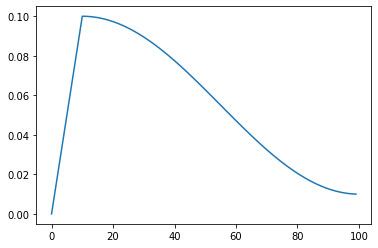

In [4]:
schedule = optax.warmup_cosine_decay_schedule(
  init_value=0.0,
  peak_value=0.1,
  warmup_steps=10,
  decay_steps=100,
  end_value=0.01,
)

optimizer = optax.chain(
  optax.clip(1.0),
  optax.adamw(learning_rate=schedule,weight_decay=0.0001),
)

eta = [schedule(i) for i in range(100)]

plt.plot(eta)

# opt = optax.clip(0.5)
# opt = optax.add_decayed_weights(0.1)
# opt = optax.sgd(learning_rate=0.1):   grads -->  updates = -grads
# optax.apply_updates:  param = param  + updates

## Use tabulate show paramters

In [7]:
class CNN(nn.Module):
  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  # flatten
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=10)(x)
    x = nn.log_softmax(x)
    return x

net = CNN()
print(net.tabulate(rd.PRNGKey(120),jnp.ones([5,32,32,3])))

                         CNN Summary                          
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ outputs             ┃ params                     ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Inputs  │ float32[5,32,32,3]  │                            │
├─────────┼─────────────────────┼────────────────────────────┤
│ Conv_0  │ float32[5,32,32,32] │ bias: float32[32]          │
│         │                     │ kernel: float32[3,3,3,32]  │
│         │                     │                            │
│         │                     │ 896 (3.6 KB)               │
├─────────┼─────────────────────┼────────────────────────────┤
│ Conv_1  │ float32[5,16,16,64] │ bias: float32[64]          │
│         │                     │ kernel: float32[3,3,32,64] │
│         │                     │                            │
│         │                     │ 18,496 (74.0 KB)           │
├─────────┼─────────────────────┼────────────────────────────┤
│ Dense_0 │ float32[5,256]      │ bias: float32[256]         │
│         │                     │ kernel: float32[4096,256]  │
│         │                     │                            │
│         │                     │ 1,048,832 (4.2 MB)         │
├─────────┼─────────────────────┼────────────────────────────┤
│ Dense_1 │ float32[5,10]       │ bias: float32[10]          │
│         │                     │ kernel: float32[256,10]    │
│         │                     │                            │
│         │                     │ 2,570 (10.3 KB)            │
├─────────┼─────────────────────┼────────────────────────────┤
│ CNN     │ float32[5,10]       │                            │
├─────────┼─────────────────────┼────────────────────────────┤
│         │               Total │ 1,070,794 (4.3 MB)         │
└─────────┴─────────────────────┴────────────────────────────┘
                                                              
             Total Parameters: 1,070,794 (4.3 MB)             

## Layer norm

In [13]:
import flax

In [80]:
key = rd.PRNGKey(0)
#net = nn.GroupNorm(6,dtype=jnp.complex64,param_dtype=jnp.float32)
shape = (100,6)
params = net.init(key,jnp.ones(shape,dtype=jnp.complex64))
x = rd.uniform(rd.PRNGKey(12),shape) + rd.uniform(rd.PRNGKey(23),shape)*(1j)
y = net.apply(params, x)

In [81]:
jnp.mean(y[:,0])

DeviceArray(1.1920928e-08-4.339218e-07j, dtype=complex64)

In [82]:
params

FrozenDict({
    params: {
        scale: DeviceArray([1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j], dtype=complex64),
        bias: DeviceArray([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j], dtype=complex64),
    },
})

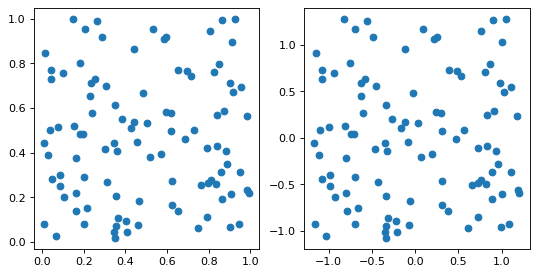

In [61]:
plt.figure(figsize=(8,4),dpi=80)
plt.subplot(1,2,1)
plt.scatter(x[0].real,x[0].imag)

plt.subplot(1,2,2)
plt.scatter(y[0].real,y[0].imag)

In [62]:
params

FrozenDict({
    params: {
        scale: DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                     1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                     1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                     1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                     1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                     1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                     1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32),
        bias: DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                     0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                     0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                     0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                     0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

## nn.vmap on Dropuout

In [10]:
import flax.linen as nn
import jax.numpy as jnp
import jax.random as random
import jax
class example(nn.Module):
    @nn.compact
    def __call__(self,x,train):
        x = nn.Dense(10)(x)
        x = nn.Dropout(0.5)(x, deterministic=not train)
        return x

net = example()
key = random.PRNGKey(0)
var = net.init(key, jnp.ones([20]), train=False)
jax.tree_map(lambda x:x.shape,var)

FrozenDict({
    params: {
        Dense_0: {
            bias: (10,),
            kernel: (20, 10),
        },
    },
})

In [34]:
vmap_example = nn.vmap(example, variable_axes={'params':0}, split_rngs={'params':True,'dropout':True},in_axes=(0,None),out_axes=(0))
net = vmap_example()
var = net.init(key, jnp.ones([5,20]), False)
net.apply(var, jnp.ones([5,20]),True, rngs={'dropout':key})

DeviceArray([[ 1.5832989 , -2.7380672 ,  4.1703033 ,  0.        ,
               1.852355  ,  4.9408903 ,  0.        ,  0.03271447,
              -0.81474555,  0.        ],
             [ 0.        ,  0.        ,  0.        ,  0.        ,
              -0.84626245,  0.34622172, -2.985825  , -1.8488363 ,
               0.        ,  0.        ],
             [ 2.3600652 ,  0.        ,  0.        ,  0.        ,
              -4.1063733 ,  0.        ,  3.2954018 ,  0.        ,
               0.        , -0.97989285],
             [ 0.7172029 ,  1.5649763 ,  0.        ,  1.7497263 ,
               0.        ,  0.        ,  0.24186362,  0.        ,
              -0.05601542, -1.8850174 ],
             [ 0.        , -1.6311474 ,  0.7221761 , -1.4749479 ,
               1.9118661 ,  2.0476017 , -5.7022343 ,  3.131647  ,
               0.        ,  1.5393133 ]], dtype=float32)

: 

In [29]:
jax.tree_map(lambda x:x.shape,var)

FrozenDict({
    params: {
        Dense_0: {
            bias: (5, 10),
            kernel: (5, 20, 10),
        },
    },
})

## My Transformer

In [32]:
from optical_flax.models_nn import Transformer, TransformerConfig
import jax
import jax.random as rd 
import jax.numpy as jnp
import flax.linen as nn
from flax import struct
key = rd.PRNGKey(0)
x = rd.normal(key,(5,100,12),dtype=jnp.complex64)
config = TransformerConfig(emb_dim=12, num_heads=2, qkv_dim=3,mlp_dim=24)
net = Transformer(config)
y,params = net.init_with_output(key, inputs=x, train=False)
net.apply(params, x[0],False) - net.apply(params, x, False)[0]

DeviceArray([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
             ...,
             [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],            dtype=complex64)

## My CNN

In [28]:
from optical_flax.models_nn import CNN
import jax.numpy as jnp
import jax.random as rd
key = rd.PRNGKey(0)
x = rd.normal(key,(5,100,2),dtype=jnp.complex64)
net = CNN(features=100)
y,params = net.init_with_output(key, x)
net.apply(params, x[0]) - net.apply(params, x)[0]

DeviceArray([[0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j],
        

## padding and frame

In [50]:
from commplax.xop import frame
def embed(inputs,k, sps,mode='wrap'):
  '''
  inputs: [L*sps,2]
  Output: [L, 2*sps*(2k+1)]
  '''
  x = jnp.pad(inputs, ((k*sps,k*sps),(0,0)), mode=mode)
  x = frame(x, (2*k+1)*sps, sps)
  x = x.reshape(x.shape[0], -1) 
  return x


class Embedding(nn.Module):
  k:int=1   # additional mimo symbols
  sps:int=8
  @nn.compact
  def __call__(self, inputs):
    # inputs: (B, L*sps,2)
    if inputs.ndim == 2:
      x = embed(inputs, self.k, self.sps)
      return x
    elif inputs.ndim == 3:
      x = jax.vmap(embed, in_axes=(0,None,None), out_axes=0)(inputs, self.k, self.sps)
      return x
    else:
      raise(ValueError)

In [51]:
L=100
sps=8
k=1
B=5
x = jnp.ones([B,L*sps,2])
y,params = Embedding(k=k,sps=sps).init_with_output(key, x)

In [52]:
y.shape

(5, 100, 48)